In [620]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot

from datetime import date

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import zscore
from pmdarima import auto_arima
import math
import pmdarima as pm
from unidecode import unidecode

import warnings
from sklearn.ensemble import IsolationForest
# Suppress warnings
warnings.filterwarnings("ignore")


## 1.1. Data collection

In [621]:
file_path = 'data/vietnam_macro_economic_by_month.csv'
data = pd.read_csv(file_path)
data.head()

,Thời gian,FDI,FDI đăng kí (lũy kế năm),FDI giải ngân (lũy kế năm),Thương mại (lũy kế năm),Xuất khẩu (lũy kế năm),Nhập khẩu (lũy kế năm),Cung tiền & tín dụng,Tăng trưởng tín dụng,Nông nghiệp,...,Chi thường xuyên,Chỉ số giá,Lạm phát cơ bản,Lạm phát,Thực phẩm,Nhà ở và VLXD,Y tế,Vận tải,Chỉ số PMI,Tăng trưởng GDP thực tế
0,-,-,% YoY,% YoY,-,% YoY,% YoY,-,% YoY,% YoY,...,% YoY,-,% YoY,% YoY,% YoY,% YoY,% YoY,% YoY,-,% YoY
1,T1 2017,-,19,6.3,-,6,3.2,-,19.5,17.7,...,NaN,-,1.9,5.2,2.4,3.5,79.4,5,51.9,5.2
2,T2 2017,-,21.5,3.3,-,16.5,23.5,-,19.6,17.5,...,NaN,-,1.5,5,-0.3,4.8,79.8,10,54.2,5.2
3,T3 2017,-,91.5,3.4,-,15.7,25.4,-,21.6,17.9,...,NaN,-,1.6,4.7,-0.9,5.3,48.7,14.6,54.6,5.2
4,T4 2017,-,53.9,3.2,-,17.4,24.8,-,20.6,17.8,...,NaN,-,1.5,4.3,-1.7,4.3,63.6,11.1,54.1,6.4


## 1.2. Data Preprocessing

### 1.2.1. Clean columns

In [622]:
data.columns

Index(['Thời gian', 'FDI', 'FDI đăng kí (lũy kế năm)',
       'FDI giải ngân (lũy kế năm)', 'Thương mại (lũy kế năm)',
       'Xuất khẩu  (lũy kế năm)', 'Nhập khẩu  (lũy kế năm)',
       'Cung tiền & tín dụng', 'Tăng trưởng tín dụng', 'Nông nghiệp',
       'Thương mại', 'Công nghiệp', 'Xây dựng', 'Cung tiền M2', 'Tài khóa',
       'Tổng thu', 'Nội địa', 'Tổng chi', 'Chi đầu tư phát triển',
       'Chi thường xuyên', 'Chỉ số giá', 'Lạm phát cơ bản', 'Lạm phát',
       'Thực phẩm', 'Nhà ở và VLXD', 'Y tế', 'Vận tải', 'Chỉ số PMI',
       'Tăng trưởng GDP thực tế'],
      dtype='object')

In [623]:
columns = ['Thoi_gian', 'FDI', 'FDI_dang_ki',
       'FDI_giai_ngan', 'Thuong_mai_luy_ke_nam',
       'Xuat_khau_luy_ke_nam', 'Nhap_khau_luy_ke_nam',
       'Cung_tien_va_tin_dung', 'Tang_truong_tin_dung', 'Nong_nghiep',
       'Thuong_mai', 'Cong_nghiep', 'Xay_dung', 'Cung_tien_M2', 'Tai_khoa',
       'Tong_thu', 'Noi_dia', 'Tong_chi', 'Chi_dau_tu_phat_trien',
       'Chi_thuong_xuyen', 'Chi_so_gia', 'Lam_phat_co_ban', 'Lam_phat',
       'Thuc_pham', 'Nha_o_va_VLXD', 'Y_te', 'Van_tai', 'Chi_so_PMI',
       'Tang_truong_GDP_thuc_te']

data.columns = columns

print("Column names after cleaning:", data.columns)

Column names after cleaning: Index(['Thoi_gian', 'FDI', 'FDI_dang_ki', 'FDI_giai_ngan',
       'Thuong_mai_luy_ke_nam', 'Xuat_khau_luy_ke_nam', 'Nhap_khau_luy_ke_nam',
       'Cung_tien_va_tin_dung', 'Tang_truong_tin_dung', 'Nong_nghiep',
       'Thuong_mai', 'Cong_nghiep', 'Xay_dung', 'Cung_tien_M2', 'Tai_khoa',
       'Tong_thu', 'Noi_dia', 'Tong_chi', 'Chi_dau_tu_phat_trien',
       'Chi_thuong_xuyen', 'Chi_so_gia', 'Lam_phat_co_ban', 'Lam_phat',
       'Thuc_pham', 'Nha_o_va_VLXD', 'Y_te', 'Van_tai', 'Chi_so_PMI',
       'Tang_truong_GDP_thuc_te'],
      dtype='object')


In [624]:
selected_columns = ['Thoi_gian', 'FDI_dang_ki', 'Xuat_khau_luy_ke_nam', 'Nhap_khau_luy_ke_nam', 'Tang_truong_tin_dung', 'Cung_tien_M2', 'Lam_phat', 'Tang_truong_GDP_thuc_te']
data = data[selected_columns]

# Drop hàng thứ 2 (hàng chứa thông tin về đơn vị)
data = data.drop(0)

data.head()
data.shape

(84, 8)

### 1.2.2. Convert date format

In [625]:
def convert_date(date_str):
    month_map = {
        'T1': '01', 'T2': '02', 'T3': '03', 'T4': '04', 'T5': '05',
        'T6': '06', 'T7': '07', 'T8': '08', 'T9': '09', 'T10': '10',
        'T11': '11', 'T12': '12'
    }
    month, year = date_str.split()
    month = month_map[month]
    return pd.to_datetime(f'{year}-{month}-01')


time_column = 'Thoi_gian'
data[time_column] = data[time_column].apply(convert_date)

data[time_column] = pd.to_datetime(data[time_column])
data.set_index(time_column, inplace=True)

data.head()

,FDI_dang_ki,Xuat_khau_luy_ke_nam,Nhap_khau_luy_ke_nam,Tang_truong_tin_dung,Cung_tien_M2,Lam_phat,Tang_truong_GDP_thuc_te
Thoi_gian,,,,,,,
2017-01-01,19,6,3.2,19.5,19.7,5.2,5.2
2017-02-01,21.5,16.5,23.5,19.6,18.1,5,5.2
2017-03-01,91.5,15.7,25.4,21.6,17.7,4.7,5.2
2017-04-01,53.9,17.4,24.8,20.6,17,4.3,6.4
2017-05-01,19.4,19,25.3,22,16.2,3.2,6.4


### 1.2.3. Handle missing value

In [626]:
data.isna().sum()

FDI_dang_ki                0
Xuat_khau_luy_ke_nam       5
Nhap_khau_luy_ke_nam       2
Tang_truong_tin_dung       0
Cung_tien_M2               0
Lam_phat                   0
Tang_truong_GDP_thuc_te    0
dtype: int64

In [627]:
xuat_khau = 'Xuat_khau_luy_ke_nam'
nhap_khau = 'Nhap_khau_luy_ke_nam'

data[xuat_khau] = data[xuat_khau].replace({None: np.nan, '': np.nan})
data[nhap_khau] = data[nhap_khau].replace({None: np.nan, '': np.nan})

data[xuat_khau] = pd.to_numeric(data[xuat_khau], errors='coerce')
data[nhap_khau] = pd.to_numeric(data[nhap_khau], errors='coerce')

# xử lí những giá trị null trong cột xuất khẩu và nhập khẩu bằng nội suy tuyến tính
data[xuat_khau] = data[xuat_khau].interpolate(method='linear')
data[nhap_khau] = data[nhap_khau].interpolate(method='linear')

missing_values = data.isna().sum()
missing_values[missing_values > 0]
data = data.astype(float)

### 1.2.4. Detect outlier

In [628]:
model = IsolationForest(n_estimators=150, contamination=0.3)
model.fit(data)
y_anomaly = model.predict(data)
data[y_anomaly == -1] = np.median(data, axis=0)

### 1.2.5. Stationarity

#### Augmented Dickey-Fuller (ADF) test

Forest Green: Strong evidence that the series is stationary (ADF statistic is less than the 1% critical value).     
Gold: Moderate evidence that the series is stationary (ADF statistic is less than the 5% critical value).   
Orange: Weak evidence that the series is stationary (ADF statistic is less than the 10% critical value).    
Indian Red: Evidence that the series is non-stationary. 

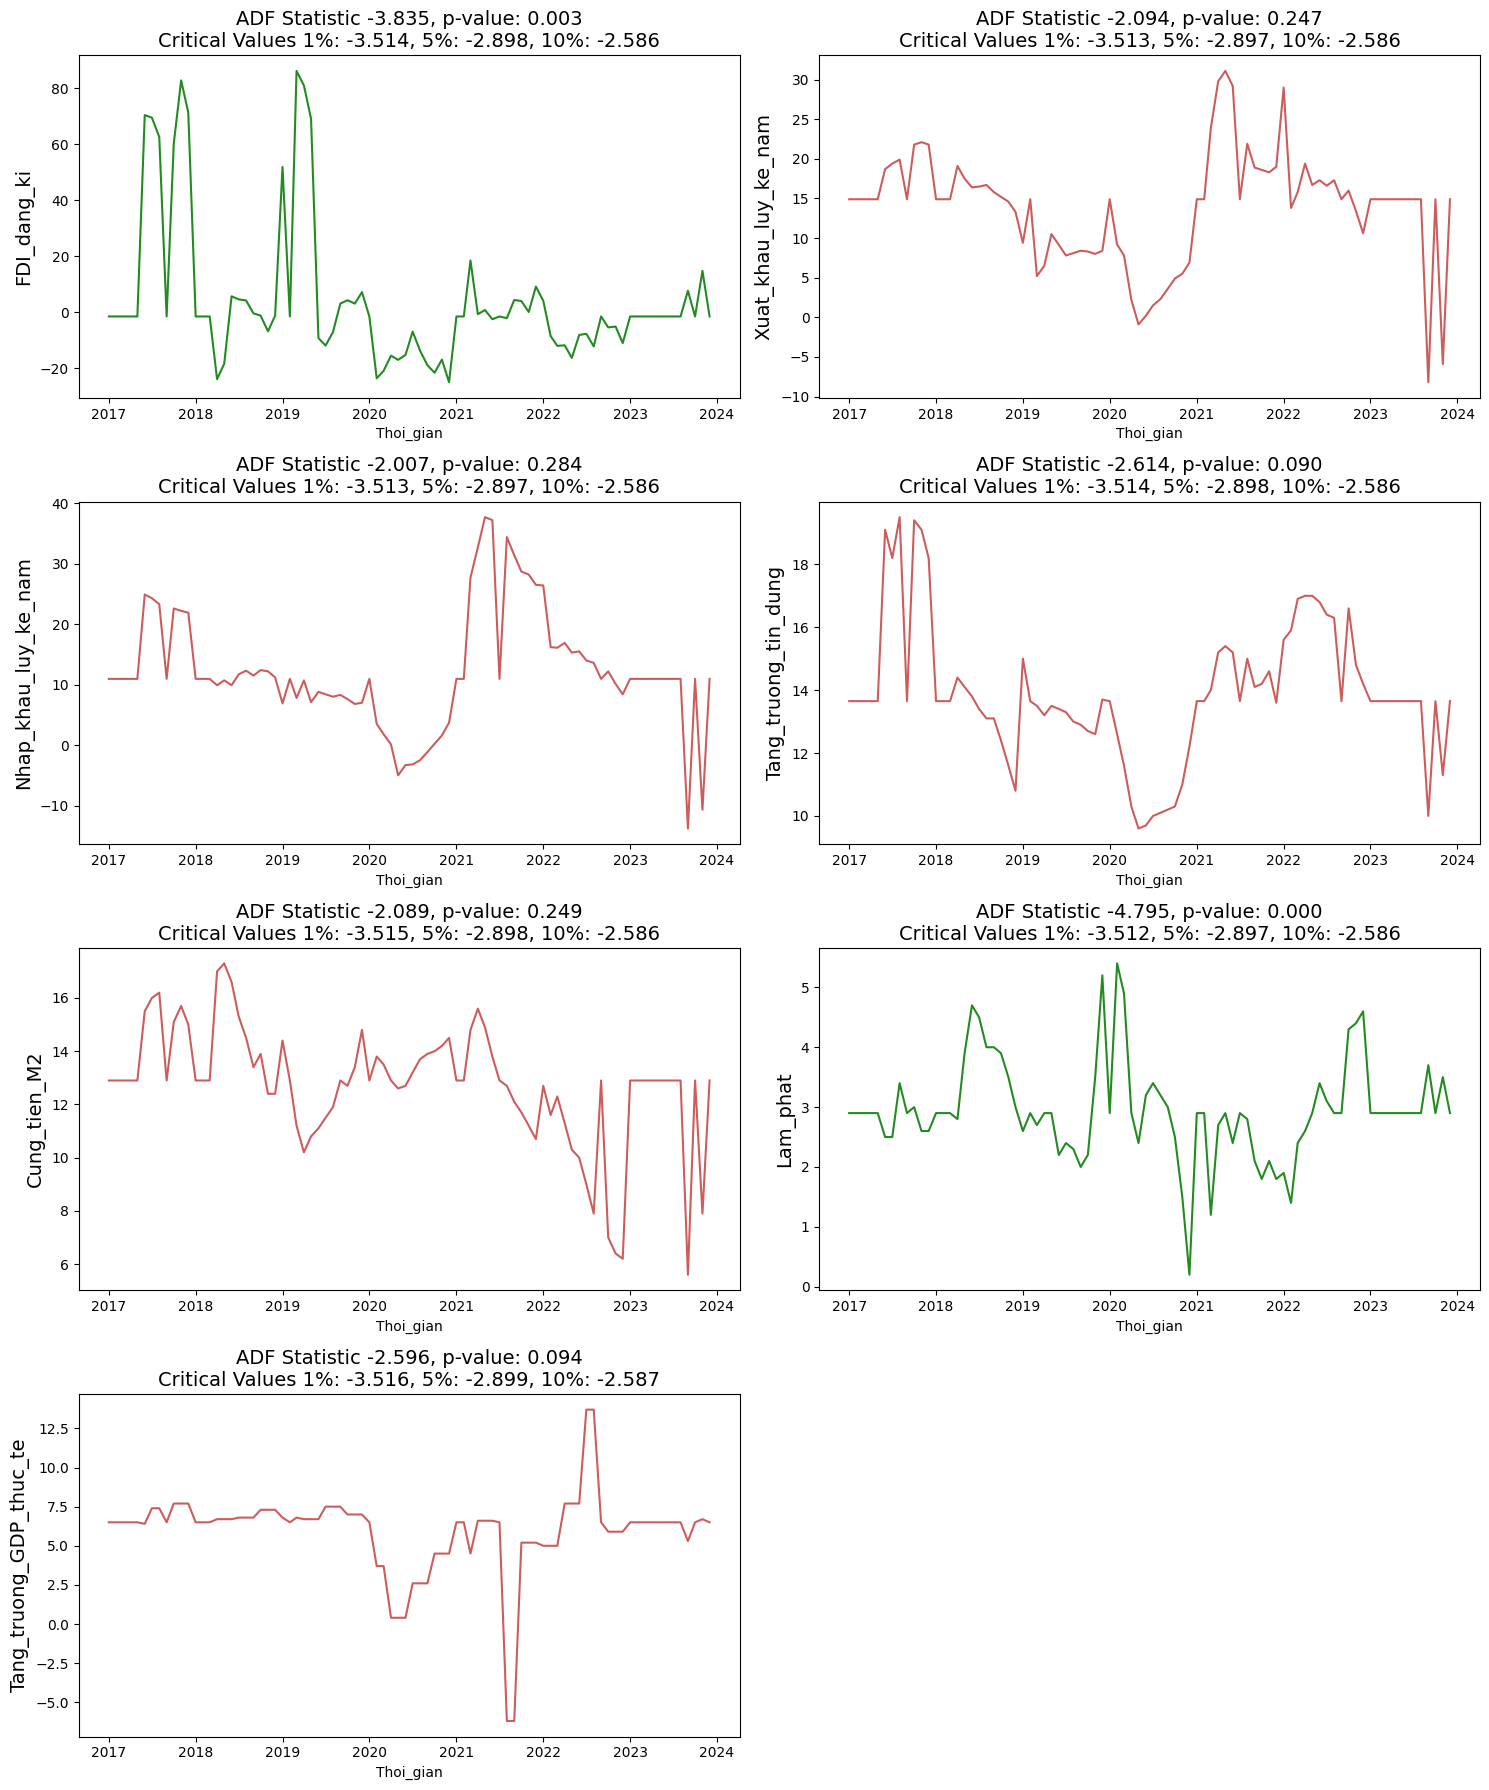

In [629]:
def visualize_adfuller_results(series, title, ax):
    result = adfuller(series) # check adf
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & (adf_stat < crit_val_1):
        linecolor = 'forestgreen'
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'gold'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'orange'
    else:
        linecolor = 'indianred'

    sns.lineplot(x=series.index, y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

f, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 18))

columns = ['FDI_dang_ki', 'Xuat_khau_luy_ke_nam', 'Nhap_khau_luy_ke_nam', 
           'Tang_truong_tin_dung', 'Cung_tien_M2', 'Lam_phat', 'Tang_truong_GDP_thuc_te']

for i, column in enumerate(columns):
    row = i // 2
    col = i % 2
    visualize_adfuller_results(data[column], column, ax[row, col])

# Remove empty subplots if has
if len(columns) % 2 != 0:
    f.delaxes(ax[len(columns) // 2, 1])

plt.tight_layout()
plt.show()


Chúng ta có thể thấy rằng ngoài 2 feature là FDI_dang_ki, Lam_phat và Tang_truong_GDP thực tế thì không có feature nào có tính dừng

### 1.4.2. Auto correlation

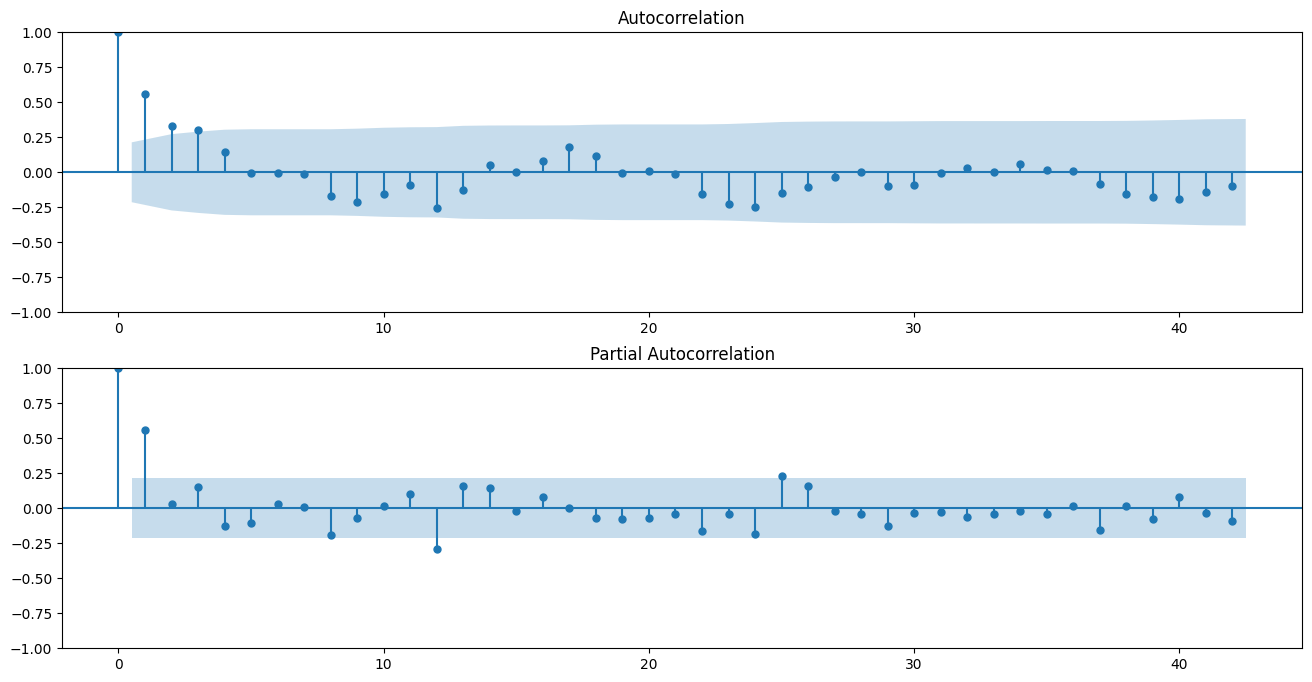

In [630]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(data.Lam_phat,lags=42, ax=ax[0])
plot_pacf(data.Lam_phat,lags=42, ax=ax[1])
plt.show()

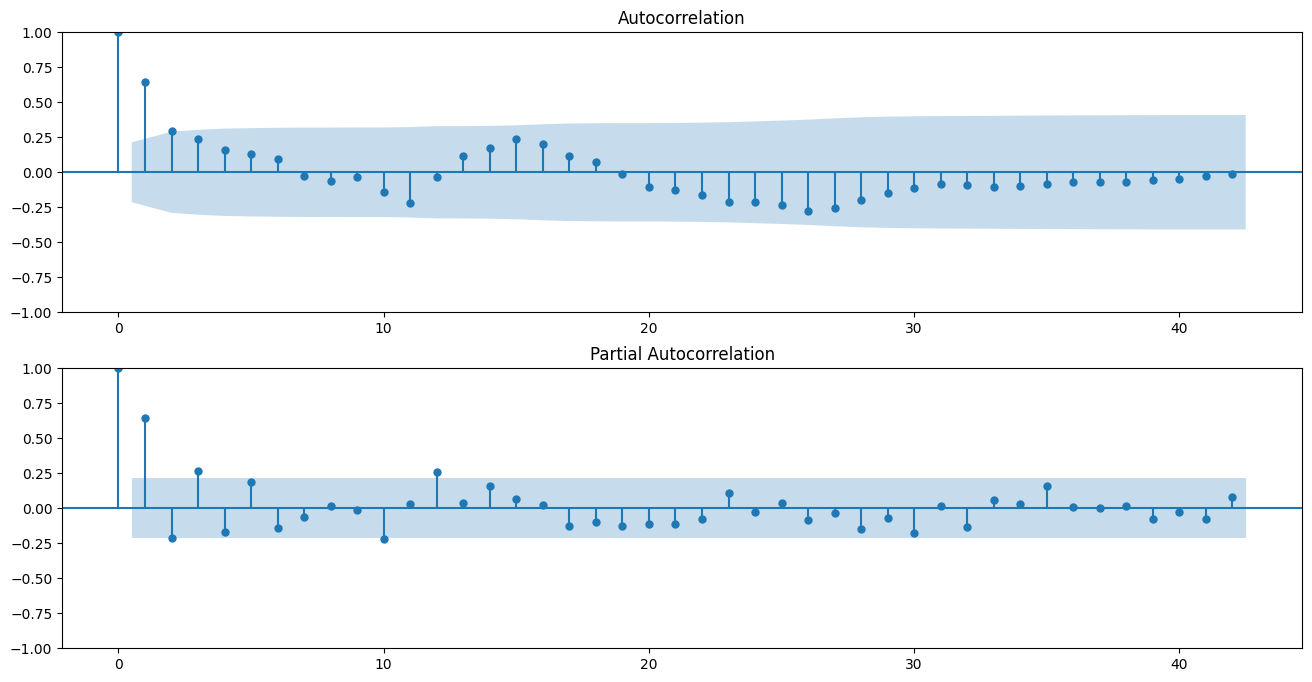

In [631]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(data.Tang_truong_GDP_thuc_te,lags=42, ax=ax[0])
plot_pacf(data.Tang_truong_GDP_thuc_te,lags=42, ax=ax[1])
plt.show()

In [632]:
train_data = data['2017-01-01':'2021-05-01']
test_data = data['2021-06-01':'2023-12-01']
target_1 = 'Lam_phat'
y_train_1 = train_data[target_1]
y_test_1 = test_data[target_1]

target_2 = 'Tang_truong_GDP_thuc_te'
y_train_2 = train_data[target_2]
y_test_2 = test_data[target_2]

## 1.6. Model

In [633]:
model = ARIMA(y_train_1, order=(3, 0, 2))
model_fit = model.fit()
print(model_fit.summary())

forecast_1 = model_fit.forecast(steps=len(y_test_1)) 
forecast_1 = forecast_1.rename('Forecast_1')
mape_lamphat = np.mean(np.abs(forecast_1 - y_test_1)/np.abs(y_test_1))

                               SARIMAX Results                                
Dep. Variable:               Lam_phat   No. Observations:                   53
Model:                 ARIMA(3, 0, 2)   Log Likelihood                 -57.327
Date:                Thu, 23 May 2024   AIC                            128.653
Time:                        16:24:03   BIC                            142.445
Sample:                    01-01-2017   HQIC                           133.957
                         - 05-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9637      0.315      9.410      0.000       2.346       3.581
ar.L1          0.2534      0.183      1.387      0.165      -0.105       0.611
ar.L2         -0.6870      0.264     -2.604      0.0

In [634]:
model = ARIMA(y_train_2, order=(3, 0, 2))
model_fit = model.fit()
print(model_fit.summary())

forecast_2 = model_fit.forecast(steps=len(y_test_2)) 
forecast_2 = forecast_2.rename('Forecast_2')
mape_gdp = np.mean(np.abs(forecast_2 - y_test_2)/np.abs(y_test_2))

                                  SARIMAX Results                                  
Dep. Variable:     Tang_truong_GDP_thuc_te   No. Observations:                   53
Model:                      ARIMA(3, 0, 2)   Log Likelihood                 -68.201
Date:                     Thu, 23 May 2024   AIC                            150.402
Time:                             16:24:03   BIC                            164.194
Sample:                         01-01-2017   HQIC                           155.706
                              - 05-01-2021                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0482      1.184      5.109      0.000       3.728       8.369
ar.L1          1.9331      0.367      5.274      0.000       1.215       2.651
ar.L2       

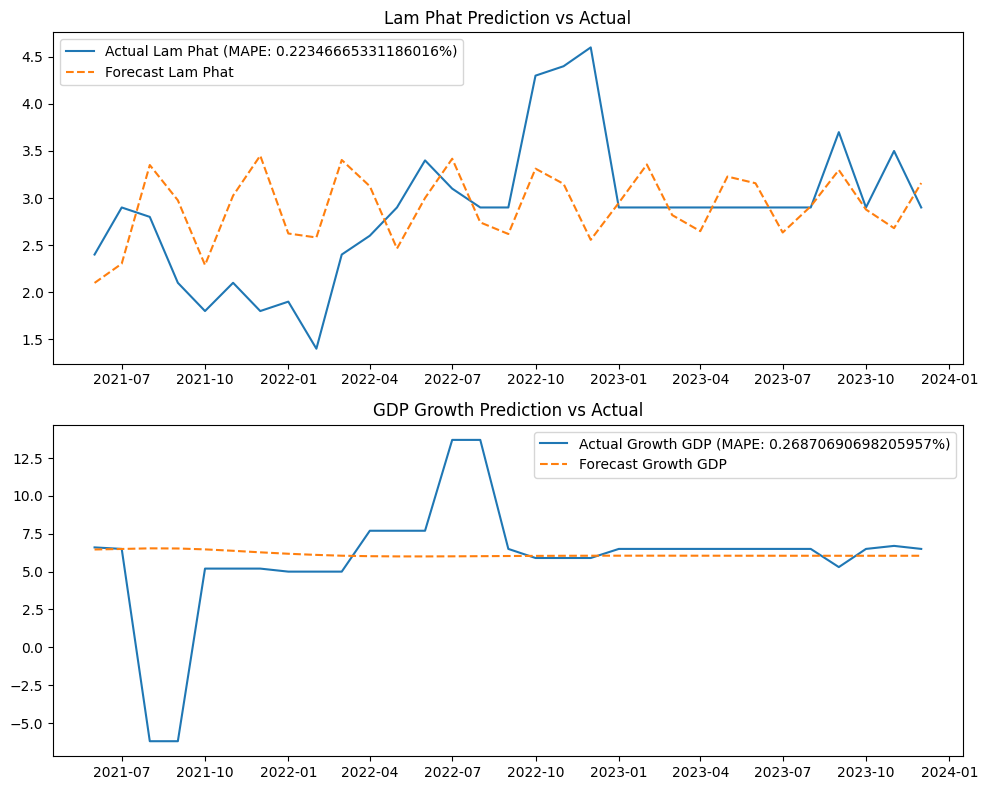

In [635]:
# Create a figure and two subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Plot for Lam Phat
ax[0].plot(y_test_1, label=f'Actual Lam Phat (MAPE: {mape_lamphat}%)')
ax[0].plot(forecast_1, label='Forecast Lam Phat', linestyle='--')
ax[0].legend()
ax[0].set_title('Lam Phat Prediction vs Actual')

# Plot for GDP Growth
ax[1].plot(y_test_2, label=f'Actual Growth GDP (MAPE: {mape_gdp}%)')
ax[1].plot(forecast_2, label='Forecast Growth GDP', linestyle='--')
ax[1].legend()
ax[1].set_title('GDP Growth Prediction vs Actual')

# Show the plot
plt.tight_layout()
plt.show()

#### Testing Causation using Granger’s Causality Test

In [636]:
# from statsmodels.tsa.stattools import grangercausalitytests
# maxlag=12
# test = 'ssr_chi2test'
# def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
#     """Check Granger Causality of all possible combinations of the Time series.
#     The rows are the response variable, columns are predictors. The values in the table 
#     are the P-Values. P-Values lesser than the significance level (0.05), implies 
#     the Null Hypothesis that the coefficients of the corresponding past values is 
#     zero, that is, the X does not cause Y can be rejected.

#     data      : pandas dataframe containing the time series variables
#     variables : list containing names of the time series variables.
#     """
#     data = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
#     for c in data.columns:
#         for r in data.index:
#             test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
#             p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
#             if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
#             min_p_value = np.min(p_values)
#             data.loc[r, c] = min_p_value
#     data.columns = [var + '_x' for var in variables]
#     data.index = [var + '_y' for var in variables]
#     return data

# grangers_causation_matrix(data, variables = data.columns)      

In [637]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(data, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(data,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(data.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(data)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
FDI_dang_ki ::  178.1     > 111.7797  =>   True
Xuat_khau_luy_ke_nam ::  105.39    > 83.9383   =>   True
Nhap_khau_luy_ke_nam ::  66.62     > 60.0627   =>   True
Tang_truong_tin_dung ::  33.98     > 40.1749   =>   False
Cung_tien_M2 ::  18.3      > 24.2761   =>   False
Lam_phat ::  4.76      > 12.3212   =>   False
Tang_truong_GDP_thuc_te ::  0.45      > 4.1296    =>   False


In [638]:
df_train, df_test = data['2017-01-01':'2021-05-01'], data['2021-06-01':'2023-12-01']

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(53, 7)
(31, 7)


In [639]:
df_differenced = df_train.diff().dropna()

In [640]:
# df_differenced = df_train.diff().dropna()

In [641]:
# df_differenced = df_train.diff().dropna()

In [642]:
# df_differenced

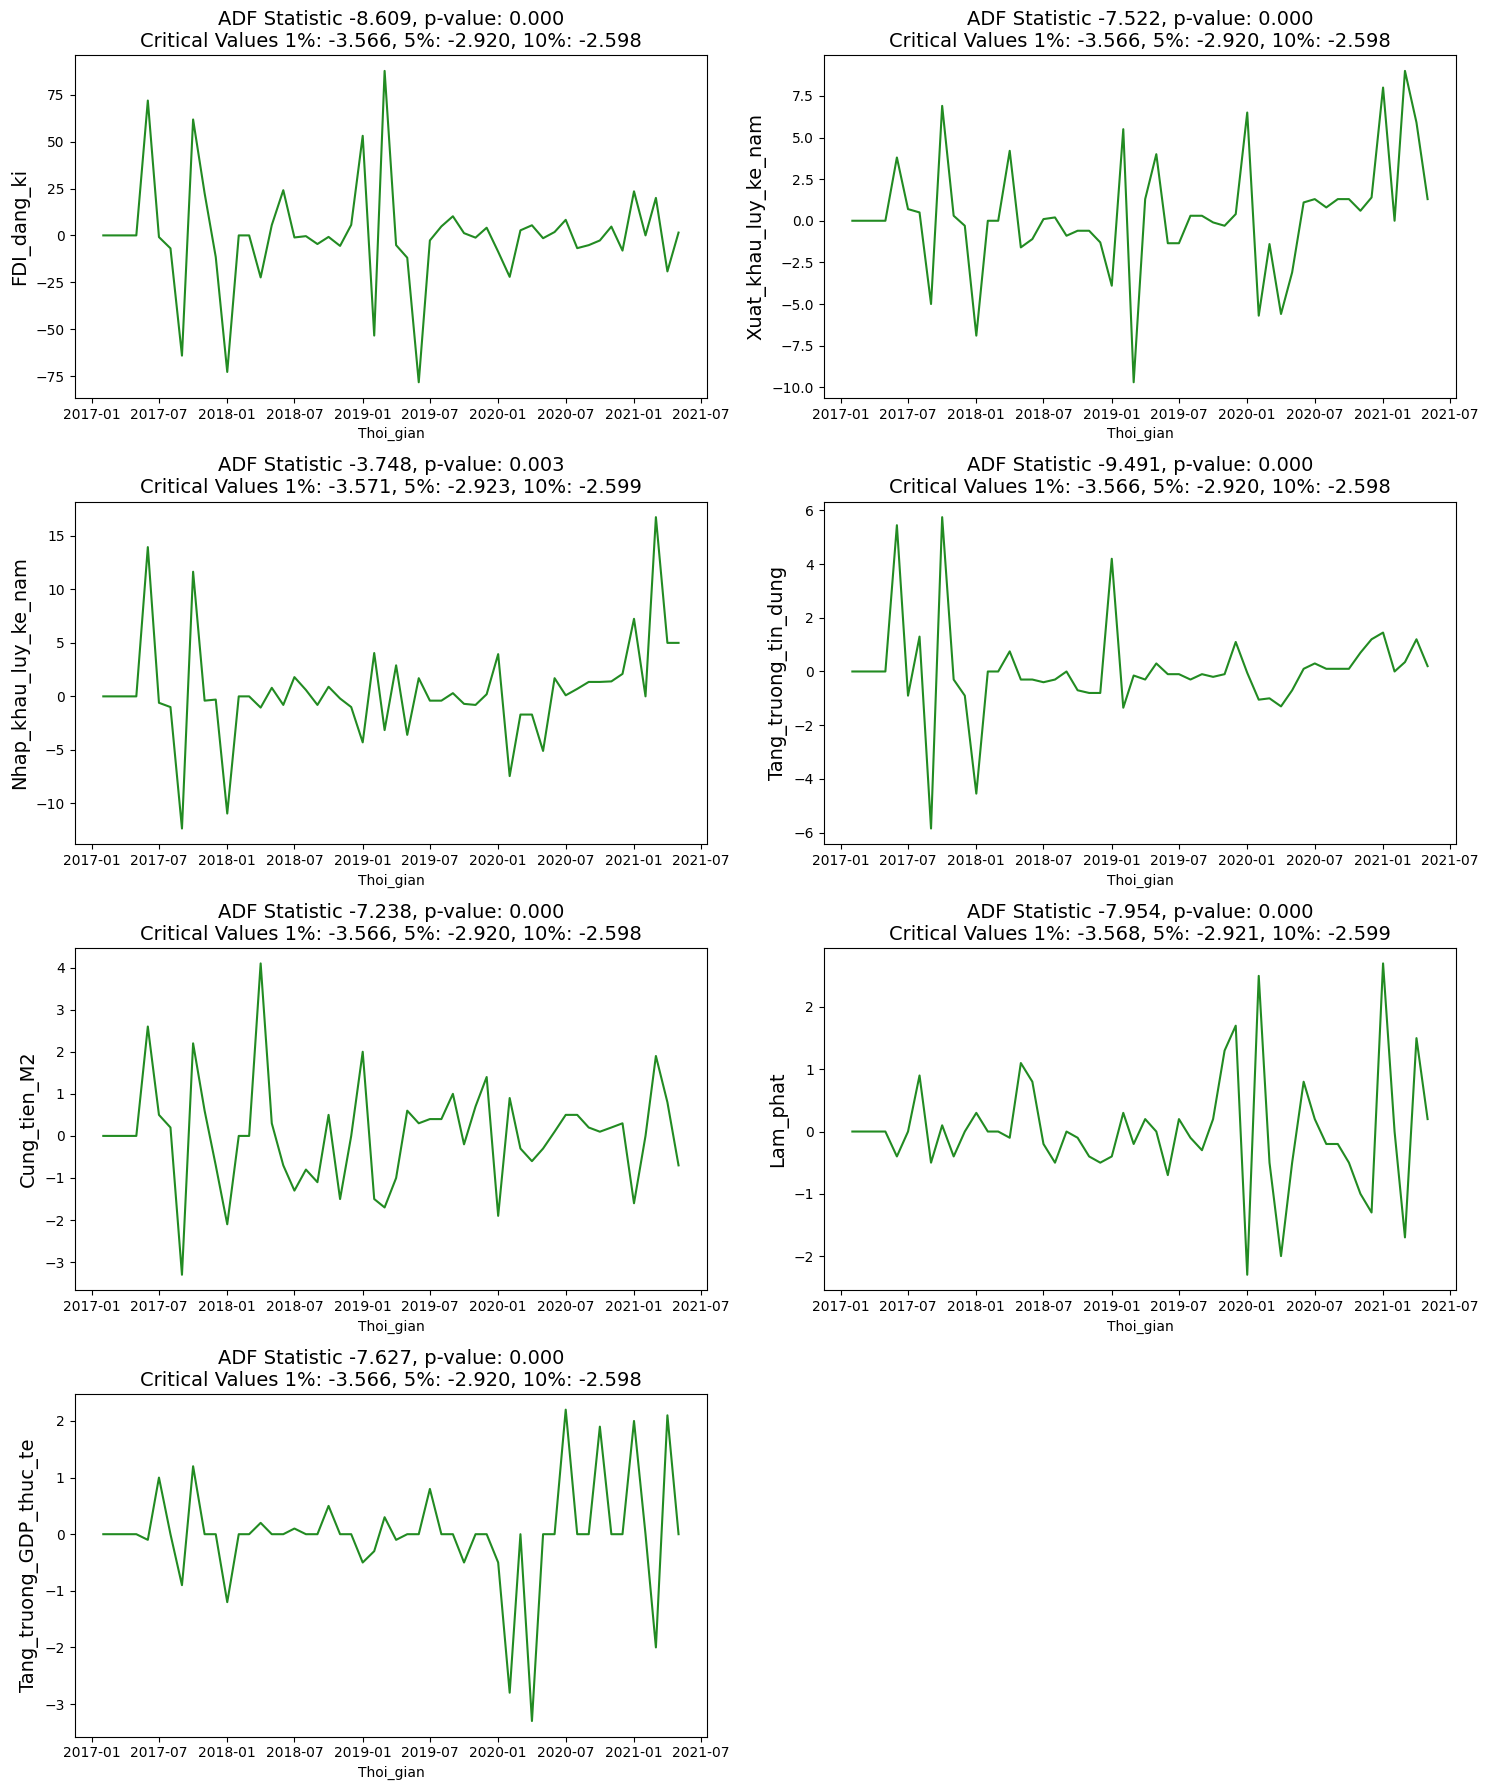

In [643]:
columns = ['FDI_dang_ki', 'Xuat_khau_luy_ke_nam', 'Nhap_khau_luy_ke_nam', 
           'Tang_truong_tin_dung', 'Cung_tien_M2', 'Lam_phat', 'Tang_truong_GDP_thuc_te']

f, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 18))

for i, column in enumerate(columns):
    row = i // 2
    col = i % 2
    visualize_adfuller_results(df_differenced[column], column, ax[row, col])

# Remove empty subplots if has
if len(columns) % 2 != 0:
    f.delaxes(ax[len(columns) // 2, 1])

plt.tight_layout()
plt.show()

In [644]:
model = VAR(df_differenced)
for i in [1,2,3,4,5]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  11.250976612528422
BIC :  13.372196915127681
FPE :  78374.93735533816
HQIC:  12.06155762876093 

Lag Order = 2
AIC :  11.502622064258478
BIC :  15.517870375657585
FPE :  113085.16915132733
HQIC:  13.03165152238995 

Lag Order = 3
AIC :  11.387132518062892
BIC :  17.332853454982004
FPE :  142816.99145760827
HQIC:  13.642930748074573 

Lag Order = 4
AIC :  11.564670399896796
BIC :  19.478291341861418
FPE :  401074.375989908
HQIC:  14.555239313204812 

Lag Order = 5
AIC :  10.120808808196369
BIC :  20.040749140769446
FPE :  762243.9271893498
HQIC:  13.85374899496962 



In [645]:
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 23, May, 2024
Time:                     16:24:07
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    19.4783
Nobs:                     48.0000    HQIC:                   14.5552
Log likelihood:          -551.315    FPE:                    401074.
AIC:                      11.5647    Det(Omega_mle):         14671.6
--------------------------------------------------------------------
Results for equation FDI_dang_ki
                                coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------
const                             -0.073576         4.814746           -0.015           0.988
L1.FDI_dang_ki                     0.034154         0.416579            0.082           0.935
L1

In [646]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

4


array([[  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ],
       [ 20.  ,   9.  ,  16.75,   0.35,   1.9 ,  -1.7 ,  -2.  ],
       [-19.2 ,   5.9 ,   5.  ,   1.2 ,   0.8 ,   1.5 ,   2.1 ],
       [  1.5 ,   1.3 ,   5.  ,   0.2 ,  -0.7 ,   0.2 ,   0.  ]])

In [647]:
# Forecast
nobs = len(df_test)
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=data.index[-nobs:], columns=data.columns + '_2d')
# df_forecast

In [648]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [649]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
# df_results.loc[:, ['FDI_dang_ki_forecast', 'Xuat_khau_luy_ke_nam_forecast', 'Nhap_khau_luy_ke_nam_forecast', 
#            'Tang_truong_tin_dung_forecast', 'Cung_tien_M2_forecast', 'Lam_phat_forecast', 'Tang_truong_GDP_thuc_te_forecast']]

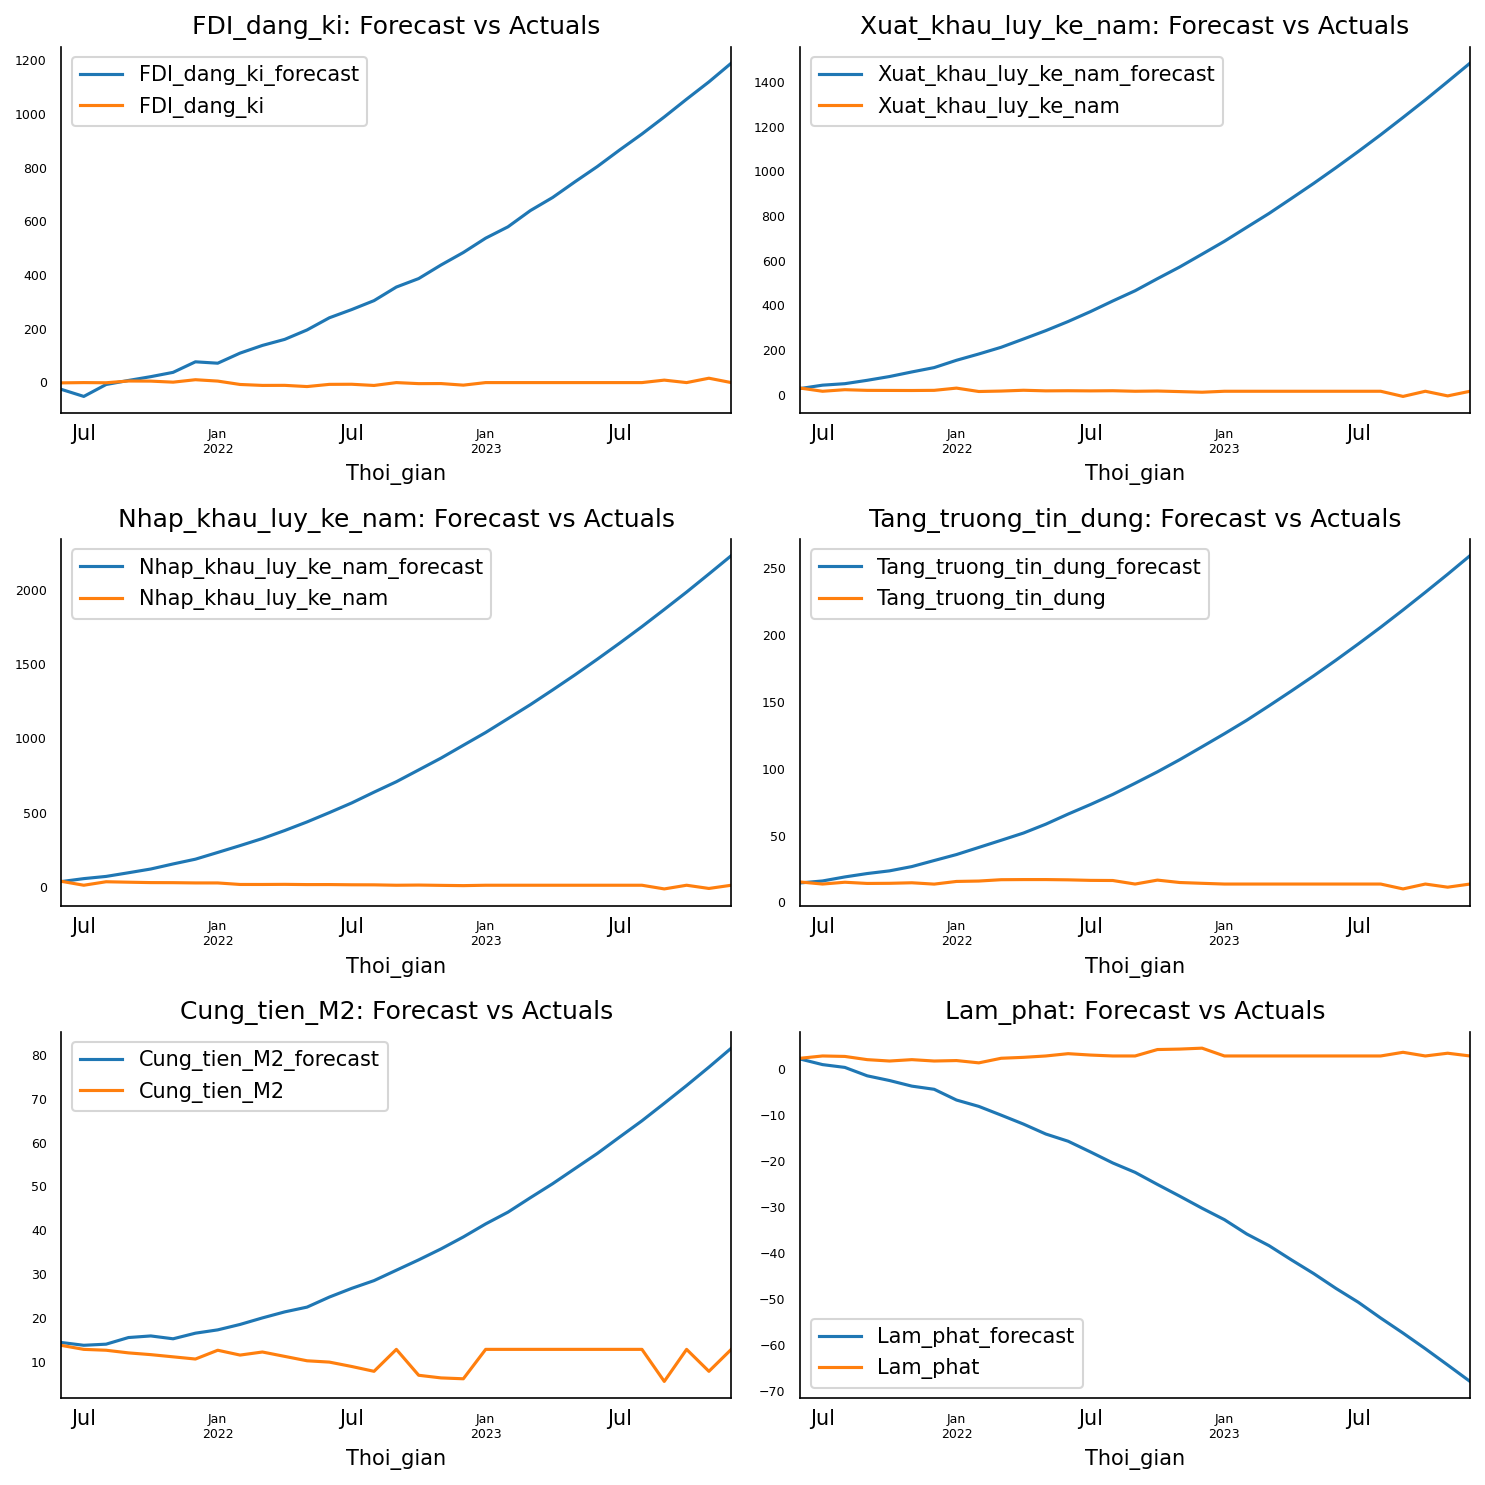

In [650]:
fig, axes = plt.subplots(nrows=int(len(data.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [651]:
def forecast_accuracy(forecast, actual):
    mae = mean_absolute_error(actual, forecast)
    mse = mean_squared_error(actual, forecast)
    rmse = np.sqrt(mse)
    return {'mae': mae, 'mse': mse, 'rmse': rmse}

def print_forecast_accuracy(forecast_col, actual_col, col_name):
    accuracy = forecast_accuracy(forecast_col, actual_col)
    print(f'\nForecast Accuracy of: {col_name}')
    for k, v in accuracy.items():
        print(f'{k.upper()}: {round(v, 4)}')

# Assuming df_results contains the forecasted values and df_test contains the actual values
forecast_columns = [
    'FDI_dang_ki_forecast', 
    'Xuat_khau_luy_ke_nam_forecast', 
    'Nhap_khau_luy_ke_nam_forecast',
    'Tang_truong_tin_dung_forecast', 
    'Cung_tien_M2_forecast', 
    'Lam_phat_forecast', 
    'Tang_truong_GDP_thuc_te_forecast'
]

for col in forecast_columns:
    forecast_col = df_results[col].values
    actual_col = df_test[col.replace('_forecast', '')].values
    print_forecast_accuracy(forecast_col, actual_col, col)



Forecast Accuracy of: FDI_dang_ki_forecast
MAE: 437.8296
MSE: 326642.4606
RMSE: 571.5264

Forecast Accuracy of: Xuat_khau_luy_ke_nam_forecast
MAE: 554.2919
MSE: 512181.1645
RMSE: 715.6683

Forecast Accuracy of: Nhap_khau_luy_ke_nam_forecast
MAE: 844.3434
MSE: 1178157.8835
RMSE: 1085.4298

Forecast Accuracy of: Tang_truong_tin_dung_forecast
MAE: 91.7076
MSE: 14241.3446
RMSE: 119.3371

Forecast Accuracy of: Cung_tien_M2_forecast
MAE: 25.8481
MSE: 1116.8096
RMSE: 33.4187

Forecast Accuracy of: Lam_phat_forecast
MAE: 29.1522
MSE: 1317.9604
RMSE: 36.3037

Forecast Accuracy of: Tang_truong_GDP_thuc_te_forecast
MAE: 25.7818
MSE: 865.9159
RMSE: 29.4264


### VARRNN